
<br>
Title: Timeseries anomaly detection using an Autoencoder<br>
Author: [pavithrasv](https://github.com/pavithrasv)<br>
Date created: 2020/05/31<br>
Last modified: 2020/05/31<br>
Description: Detect anomalies in a timeseries using an Autoencoder.<br>



<br>
## Introduction<br>
This script demonstrates how you can use a reconstruction convolutional<br>
autoencoder model to detect anomalies in timeseries data.<br>



<br>
## Setup<br>


In [96]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from pandas import read_csv
import tensorflow as tf
import random as python_random

PYTHONHASHSEED=0

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(222)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(222)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(333)


<br>
## Load the data<br>
We will use the [Numenta Anomaly Benchmark(NAB)](<br>
https://www.kaggle.com/boltzmannbrain/nab) dataset. It provides artifical<br>
timeseries data containing labeled anomalous periods of behavior. Data are<br>
ordered, timestamped, single-valued metrics.<br>
We will use the `art_daily_small_noise.csv` file for training and the<br>
`art_daily_jumpsup.csv` file for testing. The simplicity of this dataset<br>
allows us to demonstrate anomaly detection effectively.<br>


In [97]:
#master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
#master_url_root = "https://raw.githubusercontent.com/sapols/Satellite-Telemetry-Anomaly-Detection/master/Data/"
master_url_root = "https://raw.githubusercontent.com/cjackel29/ece551/"

In [98]:
#df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
#df_small_noise_url_suffix = "main/busvoltage_without_anomaly.csv"
#df_small_noise_url_suffix = "main/busvoltage_trim_without_anomaly.csv"
df_small_noise_url_suffix = "main/busvoltage_spike_removed.csv"
#df_small_noise_url_suffix = "main/BusVoltage_encoded_2.csv"
#df_small_noise_url_suffix = "main/busvoltage_smoothed_noise.csv"
#df_small_noise_url_suffix = "main/busvoltage_smoothed.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
   df_small_noise_url, parse_dates=True, index_col=0)
df_small_noise_original = df_small_noise
df_small_noise_quarter = df_small_noise[:12926]
df_small_noise_firsthalf = df_small_noise[:25852]# 25852 is 50% 
df_small_noise_secondhalf = df_small_noise[25852:]# 12926 is 25% 20282 is Jan 1, 2008
df_small_noise_section = df_small_noise[:25852]
#df_small_noise = df_small_noise_secondhalf
#df_small_noise = df_small_noise_firsthalf
df_small_noise = df_small_noise_section
#df_small_noise = pd.read_csv('art_daily_small_noise.csv', header=0, parse_dates=True, index_col=0).squeeze("columns")
#df_small_noise = pd.read_csv('busvoltage_original.csv', header=0, parse_dates=True, index_col=0).squeeze("columns")

In [99]:
master_url_root = "https://raw.githubusercontent.com/cjackel29/ece551/"

#df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url_suffix = "main/busvoltage_without_anomaly.csv"
#df_daily_jumpsup_url_suffix = "main/busvoltage_with_anomaly.csv"
#df_daily_jumpsup_url_suffix = "main/BusVoltage_not_encoded_1.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url, parse_dates=True, index_col=0)
#df_daily_jumpsup = pd.read_csv('art_daily_jumpsup.csv', header=0, parse_dates=True, index_col=0).squeeze("columns")
#df_daily_jumpsup = pd.read_csv('busvoltage_with_anomaly.csv', header=0, parse_dates=True, index_col=0).squeeze("columns")

In [100]:
print(df_small_noise.head())
df_small_noise.shape

                     busvoltage
datetime                       
2001-01-21 21:00:00   32.003189
2001-01-22 00:00:00   31.943952
2001-01-22 03:00:00   32.102344
2001-01-22 06:00:00   31.988111
2001-01-22 09:00:00   31.945055


(25852, 1)

In [101]:
print(df_daily_jumpsup.head())
df_daily_jumpsup.shape

                     busvoltage
datetime                       
2001-01-21 21:00:00   32.003189
2001-01-22 00:00:00   31.943952
2001-01-22 03:00:00   32.102344
2001-01-22 06:00:00   31.988111
2001-01-22 09:00:00   31.945055


(51704, 1)


<br>
## Visualize the data<br>
### Timeseries data without anomalies<br>
We will use the following data for training.<br>


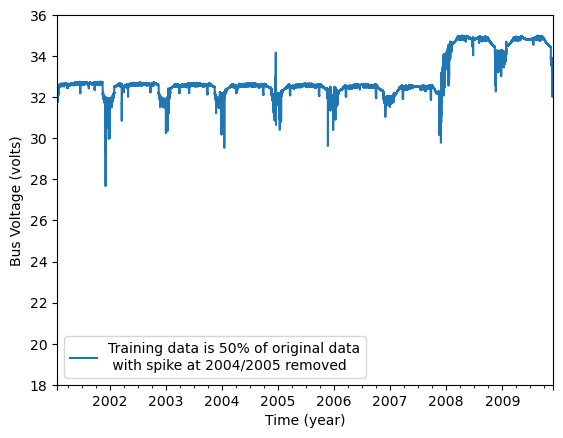

In [102]:
fig, ax = plt.subplots()
df_small_noise.plot(ax=ax)
plt.legend(["Training data is {}% of original data\n with spike at 2004/2005 removed".format(int(100*df_small_noise.shape[0]/df_small_noise_original.shape[0]))])
plt.ylim(18,36)
plt.ylabel("Bus Voltage (volts)")
plt.xlabel("Time (year)")
plt.show()


<br>
### Timeseries data with anomalies<br>
We will use the following data for testing and see if the sudden jump up in the<br>
data is detected as an anomaly.<br>


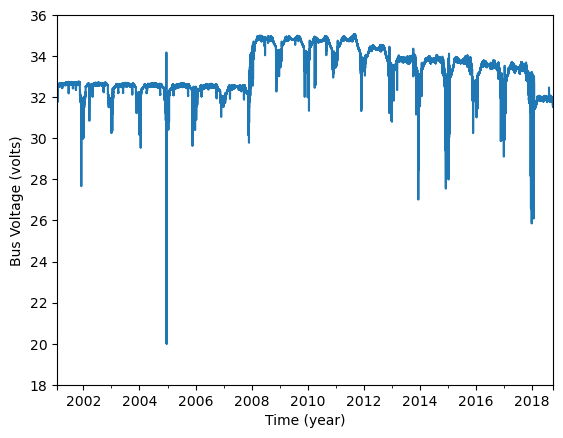

In [103]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.ylim(18,36)
plt.ylabel("Bus Voltage (volts)")
plt.xlabel("Time (year)")
plt.show()


<br>
## Prepare training data<br>
Get data values from the training timeseries data file and normalize the<br>
`value` data. We have a `value` for every 5 mins for 14 days.<br>
-   24 * 60 / 5 = **288 timesteps per day**<br>
-   288 * 14 = **4032 data points** in total<br>


Normalize and save the mean and std we get,<br>
for normalizing test data.

In [104]:
training_mean = df_small_noise.mean()
#training_mean = df_small_noise_secondhalf.mean()
#training_mean = df_small_noise_firsthalf.mean()
training_std = df_small_noise.std()
#training_std = df_small_noise_secondhalf.std()
#training_std = df_small_noise_firsthalf.std()
df_training_value = (df_small_noise - training_mean) / training_std
#df_training_value = (df_small_noise_secondhalf - training_mean) / training_std
#df_training_value = (df_small_noise_firsthalf - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 25852



<br>
### Create sequences<br>
Create sequences combining `TIME_STEPS` contiguous data values from the<br>
training data.<br>


In [105]:
TIME_STEPS = 8 # each measurement is taken every 3 hours, so there are 8 samples per day, 56 samples per week, 2912 per year

Generated training sequences for use in the model.

In [106]:
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [107]:
x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (25845, 8, 1)



<br>
## Build a model<br>
We will build a convolutional reconstruction autoencoder model. The model will<br>
take input of shape `(batch_size, sequence_length, num_features)` and return<br>
output of the same shape. In this case, `sequence_length` is 288 and<br>
`num_features` is 1.<br>


In [108]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 4, 32)             256       
                                                                 
 dropout_6 (Dropout)         (None, 4, 32)             0         
                                                                 
 conv1d_7 (Conv1D)           (None, 2, 16)             3600      
                                                                 
 conv1d_transpose_9 (Conv1DT  (None, 4, 16)            1808      
 ranspose)                                                       
                                                                 
 dropout_7 (Dropout)         (None, 4, 16)             0         
                                                                 
 conv1d_transpose_10 (Conv1D  (None, 8, 32)            3616      
 Transpose)                                           


<br>
## Train the model<br>
Please note that we are using `x_train` as both the input and the target<br>
since this is a reconstruction model.<br>


In [109]:
history = model.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, mode="min")
    ],
)

Epoch 1/100
182/182 [==============================] - 2s 7ms/step - loss: 0.1073 - val_loss: 0.0159
Epoch 2/100
182/182 [==============================] - 1s 5ms/step - loss: 0.0187 - val_loss: 0.0650
Epoch 3/100
182/182 [==============================] - 1s 6ms/step - loss: 0.0158 - val_loss: 0.0984
Epoch 4/100
182/182 [==============================] - 1s 6ms/step - loss: 0.0145 - val_loss: 0.1179
Epoch 5/100
182/182 [==============================] - 1s 5ms/step - loss: 0.0134 - val_loss: 0.1154
Epoch 6/100
182/182 [==============================] - 1s 5ms/step - loss: 0.0128 - val_loss: 0.0744
Epoch 7/100
182/182 [==============================] - 1s 5ms/step - loss: 0.0121 - val_loss: 0.1871
Epoch 8/100
182/182 [==============================] - 1s 5ms/step - loss: 0.0112 - val_loss: 0.1265
Epoch 9/100
182/182 [==============================] - 1s 5ms/step - loss: 0.0106 - val_loss: 0.1106
Epoch 10/100
182/182 [==============================] - 1s 5ms/step - loss: 0.0101 - val_lo


<br>
Let's plot training and validation loss to see how the training went.<br>


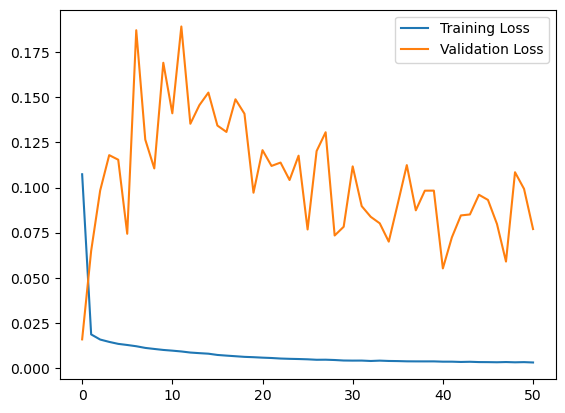

In [110]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


<br>
## Detecting anomalies<br>
We will detect anomalies by determining how well our model can reconstruct<br>
the input data.<br>
1.   Find MAE loss on training samples.<br>
2.   Find max MAE loss value. This is the worst our model has performed trying<br>
to reconstruct a sample. We will make this the `threshold` for anomaly<br>
detection.<br>
3.   If the reconstruction loss for a sample is greater than this `threshold`<br>
value then we can infer that the model is seeing a pattern that it isn't<br>
familiar with. We will label this sample as an `anomaly`.<br>


Get train MAE loss.

In [111]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

808/808 [==============================] - 2s 2ms/step


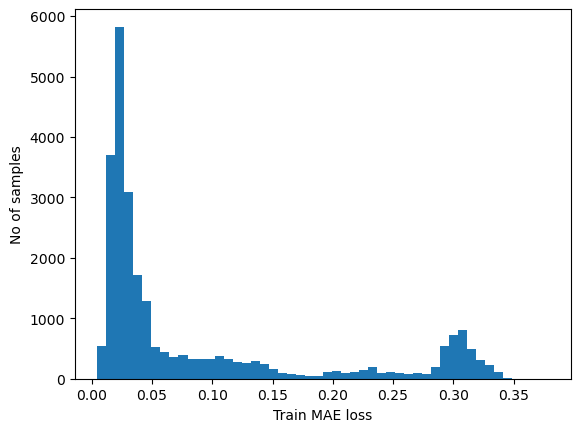

In [112]:
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

Get reconstruction loss threshold.

In [113]:
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.3787482050564606



<br>
### Compare recontruction<br>
Just for fun, let's see how our model has recontructed the first sample.<br>
This is the 288 timesteps from day 1 of our training dataset.<br>


Checking how the first sequence is learnt

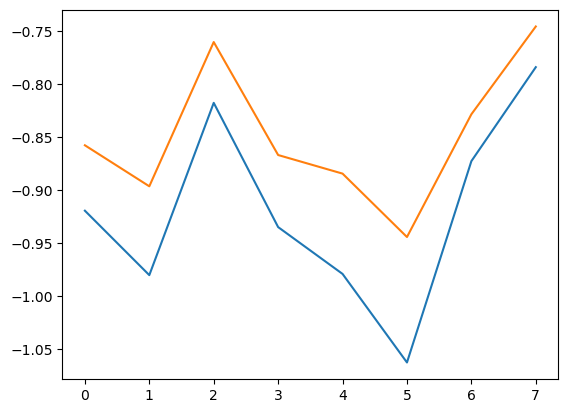

In [114]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()


<br>
### Prepare test data<br>


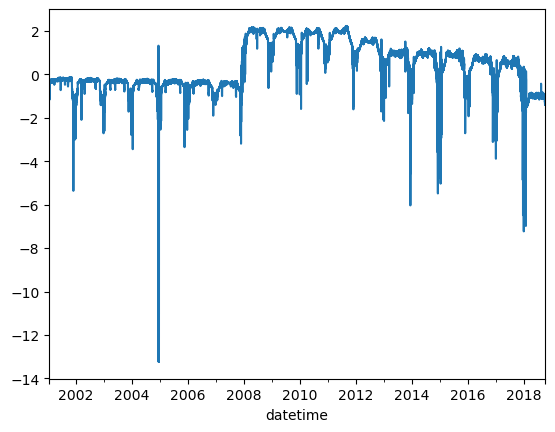

In [115]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

Create sequences from test values.

In [116]:
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)


Test input shape:  (51697, 8, 1)


In [117]:
x_test

array([[[-0.91957945],
        [-0.98038411],
        [-0.81779952],
        ...,
        [-1.06282204],
        [-0.87280196],
        [-0.78410857]],

       [[-0.98038411],
        [-0.81779952],
        [-0.93505586],
        ...,
        [-0.87280196],
        [-0.78410857],
        [-1.05494225]],

       [[-0.81779952],
        [-0.93505586],
        [-0.97925141],
        ...,
        [-0.78410857],
        [-1.05494225],
        [-0.892686  ]],

       ...,

       [[-1.36187193],
        [-1.39663165],
        [-1.3786415 ],
        ...,
        [-1.37218308],
        [-1.39463151],
        [-1.36555096]],

       [[-1.39663165],
        [-1.3786415 ],
        [-1.37339203],
        ...,
        [-1.39463151],
        [-1.36555096],
        [-1.38224427]],

       [[-1.3786415 ],
        [-1.37339203],
        [-1.3665325 ],
        ...,
        [-1.36555096],
        [-1.38224427],
        [-1.39897563]]])

Get test MAE loss.

In [118]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

1616/1616 [==============================] - 4s 2ms/step


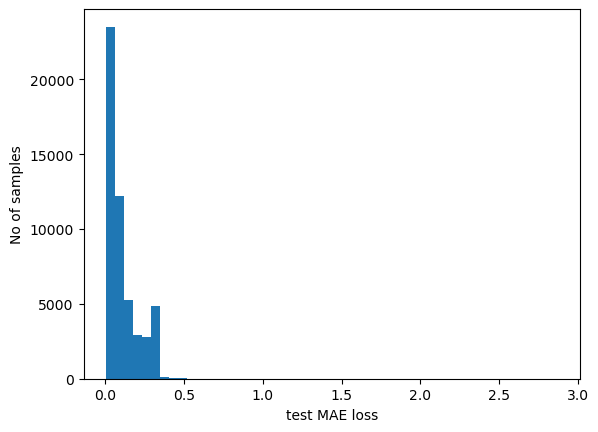

In [119]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

Detect all the samples which are anomalies.

In [120]:
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  131
Indices of anomaly samples:  (array([11405, 11406, 11407, 11408, 11409, 11410, 11411, 11412, 11413,
       11414, 11415, 11416, 11445, 11446, 11447, 11448, 11449, 11450,
       11451, 11452, 11453, 11454, 11455, 26128, 26256, 26263, 26853,
       26856, 26857, 26858, 26948, 26950, 26951, 37645, 37647, 37654,
       37655, 37658, 37660, 40491, 40522, 40523, 40524, 40525, 40526,
       40527, 40803, 40804, 40805, 40806, 40807, 40808, 40809, 40810,
       40812, 40838, 40840, 40841, 40842, 40869, 40870, 40872, 40873,
       40874, 49370, 49371, 49372, 49373, 49374, 49375, 49376, 49377,
       49378, 49379, 49380, 49381, 49382, 49383, 49384, 49385, 49386,
       49387, 49394, 49395, 49396, 49397, 49398, 49399, 49400, 49401,
       49436, 49474, 49475, 49476, 49477, 49478, 49479, 49480, 49481,
       49482, 49540, 49541, 49580, 49581, 49582, 49583, 49584, 49585,
       49586, 49587, 49588, 49676, 49677, 49678, 49679, 49682, 49685,
       49686, 49687, 49688, 


<br>
## Plot anomalies<br>
We now know the samples of the data which are anomalies. With this, we will<br>
find the corresponding `timestamps` from the original test data. We will be<br>
using the following method to do that:<br>
Let's say time_steps = 3 and we have 10 training values. Our `x_train` will<br>
look like this:<br>
- 0, 1, 2<br>
- 1, 2, 3<br>
- 2, 3, 4<br>
- 3, 4, 5<br>
- 4, 5, 6<br>
- 5, 6, 7<br>
- 6, 7, 8<br>
- 7, 8, 9<br>
All except the initial and the final time_steps-1 data values, will appear in<br>
`time_steps` number of samples. So, if we know that the samples<br>
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point<br>
5 is an anomaly.<br>


data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies

In [121]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
if len(anomalous_data_indices) == 0:
    print("No anomalies detected by model.")



<br>
Let's overlay the anomalies on the original test data plot.<br>


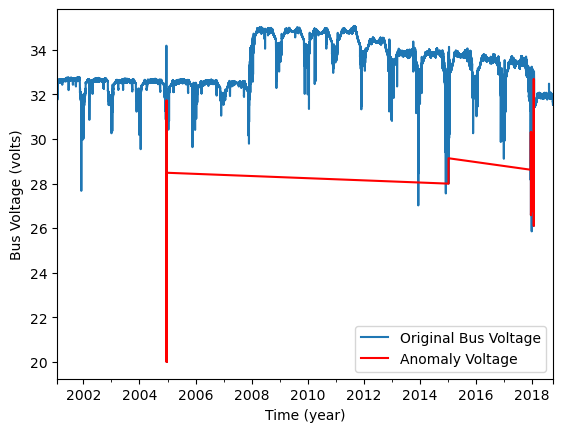

In [122]:
if len(anomalous_data_indices) > 0:
    df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
    df_subset.columns=["Anomaly Voltage"]
    df_daily_jumpsup.columns=["Original Bus Voltage"]
    fig, ax = plt.subplots()
    df_daily_jumpsup.plot(ax=ax) # removed legend=False
    df_subset.plot(ax=ax, color="r")
    plt.legend()
    plt.ylabel("Bus Voltage (volts)")
    plt.xlabel("Time (year)")
    plt.show()

    
    
    

In [123]:
from tensorflow.keras.models import load_model

model.save('my_model')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model')

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [124]:
anomalous_data_indices

[11412,
 11413,
 11414,
 11415,
 11416,
 11417,
 11452,
 11453,
 11454,
 11455,
 11456,
 40810,
 40811,
 49377,
 49378,
 49379,
 49380,
 49381,
 49382,
 49383,
 49384,
 49385,
 49386,
 49387,
 49388,
 49401,
 49402,
 49481,
 49482,
 49483,
 49587,
 49588,
 49589,
 49692,
 49693,
 49694,
 49695,
 49696,
 49697,
 49698,
 49699,
 49700]

In [125]:
df_subset

,Anomaly Voltage
datetime,
2004-12-18 09:00:00,26.086250
2004-12-18 12:00:00,24.564687
2004-12-18 15:00:00,23.043125
2004-12-18 18:00:00,21.521562
2004-12-18 21:00:00,20.000000
2004-12-19 00:00:00,31.730372
2004-12-23 09:00:00,20.000000
2004-12-23 12:00:00,21.645083
2004-12-23 15:00:00,23.290167


In [126]:
np.where(anomalies)

(array([11405, 11406, 11407, 11408, 11409, 11410, 11411, 11412, 11413,
        11414, 11415, 11416, 11445, 11446, 11447, 11448, 11449, 11450,
        11451, 11452, 11453, 11454, 11455, 26128, 26256, 26263, 26853,
        26856, 26857, 26858, 26948, 26950, 26951, 37645, 37647, 37654,
        37655, 37658, 37660, 40491, 40522, 40523, 40524, 40525, 40526,
        40527, 40803, 40804, 40805, 40806, 40807, 40808, 40809, 40810,
        40812, 40838, 40840, 40841, 40842, 40869, 40870, 40872, 40873,
        40874, 49370, 49371, 49372, 49373, 49374, 49375, 49376, 49377,
        49378, 49379, 49380, 49381, 49382, 49383, 49384, 49385, 49386,
        49387, 49394, 49395, 49396, 49397, 49398, 49399, 49400, 49401,
        49436, 49474, 49475, 49476, 49477, 49478, 49479, 49480, 49481,
        49482, 49540, 49541, 49580, 49581, 49582, 49583, 49584, 49585,
        49586, 49587, 49588, 49676, 49677, 49678, 49679, 49682, 49685,
        49686, 49687, 49688, 49689, 49690, 49691, 49692, 49693, 49694,
      